# 1D Multiexponential Decay fiting script

### Imports

In [1]:
import numpy as np
from scipy import special as _special
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import os
import pandas as pd

In [32]:
# Give us the current path
os.getcwd()

'C:\\Users\\Alejandro\\OneDrive - Universidad de Oviedo\\Escritorio'

In [33]:
# Put the path of the .dat/.txt/.csv where is the data
file_path = 'PruebaAjusteCinético1D/Trp_Cu2_wp_MA_teta_min1_pxl_235_05.08.2019.dat'

### Model's functions (Multiexponential decay) $I(t) = \sum^{n}_{i} A_i(t)\cdot e^{t/\tau_i}$ 

In [109]:

def convolved_exp(t, t0, tau, w):
    t = np.asarray(t)
    tau = np.maximum(tau, 1e-3)  
    w   = np.maximum(w, 1e-3)    

    arg1 = (w**2 - 2*tau*(t - t0)) / (2*tau**2)
    arg2 = (w**2 - tau*(t - t0)) / (np.sqrt(2)*w*tau)

    # Avoid overflow
    arg1 = np.clip(arg1, -700, 700)  
    arg2 = np.clip(arg2, -1e2, 1e2)  

    res = 0.5 * np.exp(arg1) * (1 - _special.erf(arg2))
    res = np.nan_to_num(res, nan=0.0, posinf=0.0, neginf=0.0)  # Change NaN or inf to 0
    return res
def model_1d(x, t, numExp, t0_choice='No'):
    t = np.asarray(t)
    F = np.zeros_like(t, dtype=float)
    if t0_choice == 'No':
        w = x[0]
        t0 = x[1]
        taus = x[2:2+numExp]
        As = x[2+numExp:2+numExp+numExp]
        for n in range(numExp):
            F += As[n] * convolved_exp(t, t0, taus[n], w)
    elif t0_choice == 'Fix0':
        w = x[0]
        taus = x[1:1+numExp]
        As = x[1+numExp:1+numExp+numExp]
        t0 = 0.0
        for n in range(numExp):
            F += As[n] * convolved_exp(t, t0, taus[n], w)
    else:
        raise ValueError("t0_choice debe ser 'No' o 'Fix0'")
    return F

def residuals_1d(x, t, y, numExp, t0_choice='No'):
    return model_1d(x, t, numExp, t0_choice) - y

def fit_1d(t, y, numExp=3, t0_choice='No', ini=None, bounds=None, verbose=1):
    if ini is None:
        if t0_choice == 'No':
            w0 = 0.2 * (t.max() - t.min()) if (t.max() - t.min())>0 else 0.1
            t0_0 = 0.0
            taus0 = np.array([0.5 * (3**n) for n in range(numExp)])
            As0 = np.array([(np.max(y)-np.min(y))/numExp * (0.5 if n%2==0 else 1.0) for n in range(numExp)])
            ini = np.concatenate(([w0, t0_0], taus0, As0))
        else:
            w0 = 0.2 * (t.max() - t.min()) if (t.max() - t.min())>0 else 0.1
            taus0 = np.array([0.5 * (3**n) for n in range(numExp)])
            As0 = np.array([(np.max(y)-np.min(y))/numExp * (0.5 if n%2==0 else 1.0) for n in range(numExp)])
            ini = np.concatenate(([w0], taus0, As0))

    if bounds is None:
        if t0_choice == 'No':
            lower = np.concatenate(([1e-6, t.min()-abs(t.min())*10], np.full(numExp, 1e-6), np.full(numExp, -np.inf)))
            upper = np.concatenate(([ (t.max()-t.min())*10 if (t.max()-t.min())>0 else 10, t.max()+abs(t.max())*10], np.full(numExp, 1e12), np.full(numExp, np.inf)))
        else:
            lower = np.concatenate(([1e-6], np.full(numExp, 1e-6), np.full(numExp, -np.inf)))
            upper = np.concatenate(([ (t.max()-t.min())*10 if (t.max()-t.min())>0 else 10], np.full(numExp, 1e12), np.full(numExp, np.inf)))
        bounds = (lower, upper)

    res = least_squares(residuals_1d, ini, args=(t, y, numExp, t0_choice), bounds=bounds, verbose=verbose, jac='2-point')

    J = res.jac
    try:
        cov = np.linalg.inv(J.T @ J)
        dof = max(1, (len(y) - len(res.x)))
        s_sq = np.sum(res.fun**2) / dof
        cov = cov * s_sq
    except np.linalg.LinAlgError:
        cov = np.zeros((len(res.x), len(res.x)))
    return res, res.x, cov


### Data Reduction

In [110]:
# Read the data
data1 = pd.read_csv(file_path, delimiter='\t', header=None,skiprows=1)
t = data1[0].values.astype(float)
y = data1[1].values.astype(float)

# Erase infs & NaN
mask = np.isfinite(t) & np.isfinite(y)
t, y = t[mask], y[mask]
order = np.argsort(t)
t, y = t[order], y[order]

# Normalization
baseline = np.mean(y[:10])
y_raw = y.copy()
y = y - baseline
scale = np.max(np.abs(y))
y = y / scale


### Fitting

In [107]:
# Fit to 2 exponential model
numExp = 2
t0_choice = 'No'
ini = np.array([1.0, 0.5, 1.0, 20.0, 0.5, -0.3])
lower = [1e-6, -5.0, 1e-6, 1e-6, -np.inf, -np.inf]
upper = [10.0, np.max(t), 1e6, 1e6, np.inf, np.inf]
bounds = (lower, upper)

In [105]:
# Fit to 3 exponential model
numExp = 3
t0_choice = 'No'    
ini = np.array([
    0.5,      # w
    0.0,      # t0
    0.5, 2.0, 10.0,   # taus (3)
    1.0, -0.3, 0.2    # Amps (3)
])

lower = (
    [1e-6, -5.0] +      # w, t0
    [1e-6]*3 +          # tau1..tau3
    [-np.inf]*3         # A1..A3
)

upper = (
    [10.0, np.max(t)] +  # w, t0
    [1e6]*3 +            # tau1..tau3
    [np.inf]*3           # A1..A3
)

bounds = (lower, upper)

In [111]:
# Fit to 4 exponential model
numExp = 4
t0_choice = 'No'    

# Inicialización de parámetros: [w, t0, tau1..tau4, A1..A4]
ini = np.array([
    0.5,      # w
    0.0,      # t0
    0.5, 2.0, 10.0, 25.0,   # taus (4)
    1.0, -0.3, 0.2, 0.5     # Amps (4)
])

# Límites inferiores
lower = (
    [1e-6, -5.0] +      # w, t0
    [1e-6]*4 +          # tau1..tau4
    [-np.inf]*4         # A1..A4
)

# Límites superiores
upper = (
    [10.0, np.max(t)] +  # w, t0
    [1e6]*4 +            # tau1..tau4
    [np.inf]*4           # A1..A4
)

bounds = (lower, upper)


`ftol` termination condition is satisfied.
Function evaluations 152, initial cost 1.3423e+01, final cost 1.2068e+00, first-order optimality 1.99e+02.

=== Resultados ajustados ===
w  = 0.1573 ± 0.0372
t0 = 0.2184 ± 0.1162
tau1 = 0.0751 ± 0.1993
A1   = 1.796477 ± 5.911433
tau2 = 0.9935 ± 0.1313
A2   = 0.827328 ± 0.090297
tau3 = 135.7399 ± 6273.1486
A3   = 0.029544 ± 1.860606
tau4 = 52718.8012 ± 154263168.1545
A4   = 0.089032 ± 1.869652


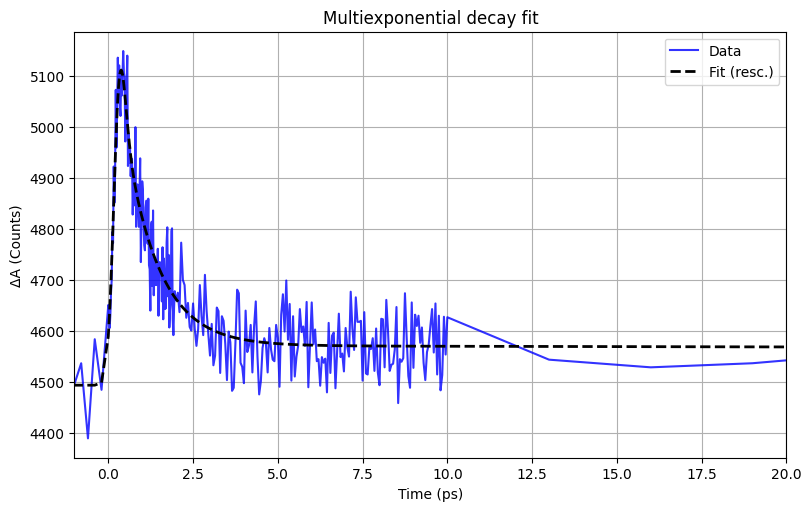

In [114]:
res, xopt, cov = fit_1d(t, y, numExp=numExp, t0_choice=t0_choice, ini=ini, bounds=bounds, verbose=1)

#  Parameters
w_opt = xopt[0]
t0_opt = xopt[1]
taus_opt = xopt[2:2+numExp]
As_opt = xopt[2+numExp:2+numExp+numExp]
errs = np.sqrt(np.abs(np.diag(cov))) if cov.size else np.zeros_like(xopt)

print("\n=== Resultados ajustados ===")
print(f"w  = {w_opt:.4f} ± {errs[0]:.4f}")
print(f"t0 = {t0_opt:.4f} ± {errs[1]:.4f}")
for n in range(numExp):
    print(f"tau{n+1} = {taus_opt[n]:.4f} ± {errs[2+n]:.4f}")
    print(f"A{n+1}   = {As_opt[n]:.6f} ± {errs[2+numExp+n]:.6f}")

# Model fit
y_fit_norm = model_1d(xopt, t, numExp=numExp, t0_choice=t0_choice)
y_fit = y_fit_norm * scale + baseline

# Plots
plt.figure(figsize=(8,5),constrained_layout=True)
plt.plot(t, y_raw, 'b', label='Data', alpha=0.8)
plt.plot(t, y_fit, 'k--', lw=2, label='Fit (resc.)')
plt.xlabel('Time (ps)')
plt.ylabel('ΔA (Counts)')
plt.title('Multiexponential decay fit')
plt.xlim(-1, 20)
plt.legend()
plt.grid(True)
plt.show()

### Saving Data

In [113]:
# Save the results in the same file of the .csv/.dat/.txt
input_name = os.path.basename(file_path)
output_name = os.path.splitext(input_name)[0] + "_fit.csv"
output_path = os.path.join(os.path.dirname(file_path), output_name)

df_out = pd.DataFrame({
    'Tiempo_ps': t,
    'Datos_originales': y_raw,
    'Modelo_ajuste': y_fit
})
df_out.to_csv(output_path, index=False, float_format='%.6f')
print(f"\n File saved in:\n{output_path}")

# Save the fit parameters in the same file
output_params_name = os.path.splitext(input_name)[0] + "_taus_amplitudes.txt"
output_params_path = os.path.join(os.path.dirname(file_path), output_params_name)
As_opt_real = As_opt * scale

with open(output_params_path, 'w', encoding='utf-8') as f:
    f.write("=== Tau and Amplitudes fit (or.units) ===\n\n") #or = original units
    f.write("{:<10} {:>15} {:>15}\n".format("Parameter", "Value", "Error"))
    f.write("-"*40 + "\n")
    for n in range(numExp):
        f.write("{:<10} {:>15.6f} {:>15.6f}\n".format(f"tau{n+1}", taus_opt[n], errs[2+n]))
    for n in range(numExp):
        f.write("{:<10} {:>15.6f} {:>15.6f}\n".format(f"A{n+1}", As_opt_real[n], errs[2+numExp+n]*scale))

print(f"\n τ and Amplitudes saved in:\n{output_params_path}")



 File saved in:
PruebaAjusteCinético1D\Trp_Cu2_wp_MA_teta_min1_pxl_235_05.08.2019_fit.csv

 τ and Amplitudes saved in:
PruebaAjusteCinético1D\Trp_Cu2_wp_MA_teta_min1_pxl_235_05.08.2019_taus_amplitudes.txt
